# 知識點
Filter 的操作在電腦視覺中可以把這個過程稱為「抽取特徵」，而特徵可以非常直覺的解釋為「圖片中最特別的地方」，例如邊緣、輪廓、紋理等資訊。

SIFT 就是其中一種表徵 (appearance feature)，它會基於局部的外觀特徵，進一步考慮到圖片特徵的狀況，因此具有以下特性：
- 縮放不變性，旋轉不變性。
- 光線與雜訊容忍度高。

在 SIFT 演算法中可以了解到如何做關鍵點偵測，以及如何抽出 SIFT 特徵來敘述關鍵點，下圖即為 SIFT 特徵的範例：
<img src='https://miro.medium.com/max/450/1*a9gM_BNbz9W_2jxC1UtYqw.jpeg'>

SIFT 主要考慮到的問題之一是尺度，以 [Harris Corner Detection](https://docs.opencv.org/master/dc/d0d/tutorial_py_features_harris.html) 為例，Filter 可以偵測到範圍以內的角落點，但是同樣的 pattern 放大後以同樣的 Filter 去偵測就會失敗 (類似瞎子摸象的概念)。

SIFT 會以邊緣檢測抽取特徵，但不是使用 Sobel，而是改為使用 DoG (概念上是 LoG，但因為考慮計算量才做此選擇)。

兩者的說明如下：
- Laplacian of Gaussian (LoG)：先對圖片做 Gaussian Blur 再算二階導數取得邊緣。

- Difference of Gaussian (DoG)：圖片經過不同程度的縮放後 (一種 scale 稱為一個 octave)，每種 scale 的圖片經過不同程度的 Gaussian Blur 後，最後合併得到一個 Gaussian Pyramid，其差值即為 DoG，而這個結果可以視為 LoG 的近似值 (沒有做二階導數)。

> 這邊討論的特徵主要是物體的邊緣，而二階導數是個適合的工具來找出邊緣，因此才會討論 LoG 與 DoG，詳細請參考 [Laplacian/Laplacian of Gaussian](https://homepages.inf.ed.ac.uk/rbf/HIPR2/log.htm)。

前面提到的 DoG 影像包含多種尺度，接著要針對每個 pixel 判斷是否為極值，判斷範圍 8+18 = 26 (自己本身周遭的 8 個 pixel + 同一個 scale 圖片但不同模糊尺度之相鄰位置共 9*2=18 個 pixel)。

假如該 pixel 為判斷範圍內的最大 / 最小值，則將其設為有興趣的關鍵點，經過多尺度極值偵測之後，會得到許多候選的關鍵點，其中也包含許多噪音跟邊緣的關鍵點，因此需要更進一步根據周遭資訊來修正並過濾關鍵點：
- 鄰近資料差補：主要根據相鄰資訊來修正極值的位置。
- 過濾不明顯關鍵點：根據計算曲率來判斷是否為不明顯的關鍵點。
- 過濾邊緣關鍵點：根據計算曲率來判斷是否為不明顯的關鍵點。

主曲率計算請參考 [Math 660: Principal curvatures](http://www.math.union.edu/~jaureguj/principal_curvatures.pdf)


前面我們定義並過濾了許多關鍵點，但是關鍵點只有包含尺度跟位置，SIFT 還想要保有旋轉不變性，因此要給關鍵點定義一個方向：
- 以每 10 度為單位計算周圍的梯度值。
- 梯度值最大的方向當作是該關鍵點的主要方向。

賦與關鍵點位置，尺度，方向確保移動，縮放，旋轉的不變性後，還需要額外建立描述子來確保不同光線跟視角也有不變性，因此需要關鍵點描述子：
- 描述子會正規化成 128 維的特徵向量。
- 以關鍵點周圍 16*16 的區域共 4*4 的子區域，計算 8 個方向的直方圖，共 4*4*8 = 128 維的特徵向量。
> 每個關鍵點都會產生 128 維的特徵，而圖片會產生 N 個關鍵點，也就是會產生 (N, 128) 維度特徵。

整體 SIFT 演算法的物理意義如下：
- 從 LoG 變為 DoG 取得多尺度空間
- 透過極值找候選的關鍵點
- 透過主曲率過濾關鍵點
- 透過區域劃分決定方向並正規化成 128 維向量

DoG 詳解請參考 [OpenCV Tutorials - Feature Detection and Description - SIFT](https://silverwind1982.pixnet.net/blog/post/241014085)

詳細的數學推導請參考 [SIFT特征提取分析](https://blog.csdn.net/abcjennifer/article/details/7639681)

# 範例

取得 SIFT 特徵

- 轉成灰階圖片
- 需要額外安裝 OpenCV 相關套件

In [1]:
!pip install opencv-contrib-python==3.4.2.16

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

img = cv2.imread('img/lena.png')

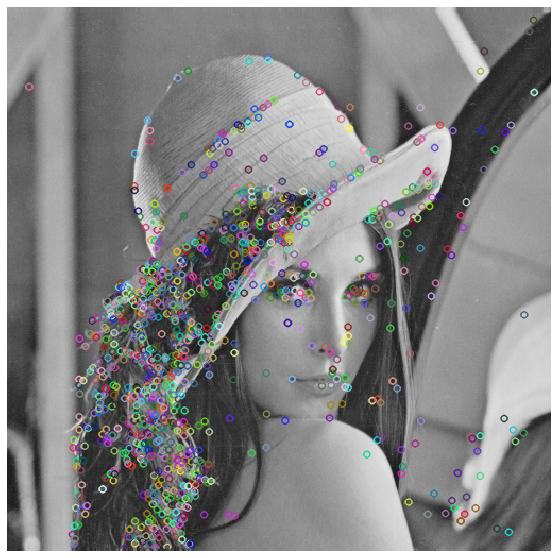

In [3]:
# 轉灰階圖片
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 建立 SIFT 物件
SIFT_detector = cv2.xfeatures2d.SIFT_create()

# 取得 SIFT 關鍵點位置
keypoints = SIFT_detector.detect(img_gray, None)

#　畫圖 + 顯示圖片
img_show = cv2.drawKeypoints(img_gray, keypoints, img)

plt.figure(figsize=(12, 10))
plt.axis('off')
plt.imshow(img_show);

思考如果我們把 RGB channel 個別拆開計算 SIFT 是否會得到跟灰階圖的特徵相同？
回顧一下 SIFT 的演算法是否會考慮到顏色的變化？

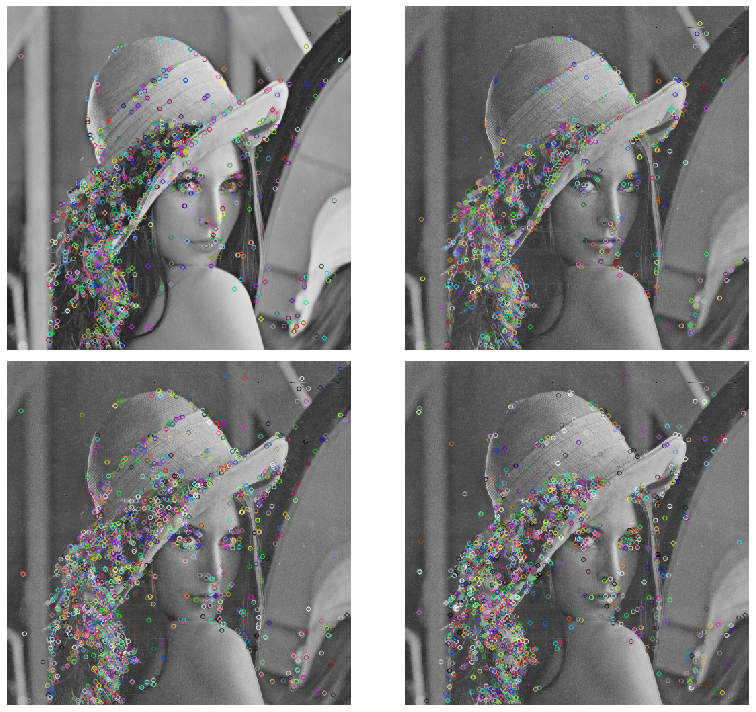

In [4]:
img = cv2.imread('img/lena.png')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_r, img_g, img_b = img[..., 0], img[..., 1], img[..., 2]

# 建立 SIFT 物件
SIFT_detector = cv2.xfeatures2d.SIFT_create()

# 取得 SIFT 關鍵點位置
keypoints_r = SIFT_detector.detect(img_r, None)
keypoints_g = SIFT_detector.detect(img_g, None)
keypoints_b = SIFT_detector.detect(img_b, None)


# # 畫圖 + 顯示圖片
img_show_r = cv2.drawKeypoints(img_r, keypoints_r, img)
img = cv2.imread('img/lena.png')
img_show_g = cv2.drawKeypoints(img_g, keypoints_g, img)
img = cv2.imread('img/lena.png')
img_show_b = cv2.drawKeypoints(img_b, keypoints_b, img)

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs[0, 0].imshow(img_show)
axs[0, 0].axis('off')
axs[0, 1].imshow(img_show_r)
axs[0, 1].axis('off')
axs[1, 0].imshow(img_show_g)
axs[1, 0].axis('off')
axs[1, 1].imshow(img_show_b)
axs[1, 1].axis('off')
plt.tight_layout()